#  <center>**Maestría en Ciencia de Datos y Analítica**</center>
## <center>**Examen 1: Algebra de Datos**</center>
### <center>**Autor**:</center>
#### <center>**Sebastian Carvalho Salazar**</center>

# Predicción de insuficiencia cardíaca

## Sobre el conjunto de datos

Extraido de: [Kaggle: Predicting Heart Failure Dataset](https://www.kaggle.com/datasets/whenamancodes/heart-failure-clinical-records)


Las enfermedades cardiovasculares (ECV) son la causa número 1 de muerte a nivel mundial, y se estima que 17.9 millones de vidas se pierden cada año, lo que representa el 31% de todas las muertes en todo el mundo. La insuficiencia cardíaca es un evento común causado por las ECV, y este conjunto de datos contiene 12 características que pueden usarse para predecir la mortalidad por insuficiencia cardíaca.

La mayoría de las enfermedades cardiovasculares se pueden prevenir abordando factores de riesgo conductuales como el consumo de tabaco, la dieta poco saludable y la obesidad, la inactividad física y el uso nocivo del alcohol, mediante estrategias de toda la población.

Las personas con enfermedad cardiovascular o con alto riesgo cardiovascular (debido a la presencia de uno o más factores de riesgo como hipertensión, diabetes, hiperlipidemia o enfermedad ya establecida) necesitan detección y manejo temprano, en el que un modelo de aprendizaje automático puede ser de gran ayuda.

### Información del atributo:

Trece características clínicas (13):

- **edad**: edad del paciente (años)
- **anemia**: disminución de glóbulos rojos o hemoglobina (booleano)
- **presión arterial alta**: si el paciente tiene hipertensión (booleana)
- **creatinina fosfoquinasa (CPK)**: nivel de la enzima CPK en la sangre (mcg/L)
- **diabetes**: si el paciente tiene diabetes (booleana)
- **fracción de eyección**: porcentaje de sangre que sale del corazón en cada contracción (porcentaje)
- **plaquetas**: plaquetas en la sangre (kiloplaquetas/ml)
- **sexo**: mujer u hombre (binario)
- **creatinina sérica**: nivel de creatinina sérica en la sangre (mg/dL)
- **sodio sérico**: nivel de sodio sérico en la sangre (mEq/L)
- **fumar**: si el paciente fuma o no (booleano)
- **tiempo**: período de seguimiento (días)
- [**objetivo**] **evento de muerte**: si el paciente falleció durante el período de seguimiento (booleano)

# Librerias
---

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pickle

# Importar datos
---

In [ ]:
path = '/content/Heart Failure Clinical Records.csv'
df = pd.read_csv(path)

In [ ]:
df.head(5)

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [ ]:
df['age_bool'] = df['age'].apply(lambda x : 0 if int(x) < 50 else 1)

In [ ]:
df[['age','age_bool']].sample(3)

,age,age_bool
78,75.0,1
75,60.0,1
193,73.0,1


# Balance de datos (Feature)
---

<Axes: >

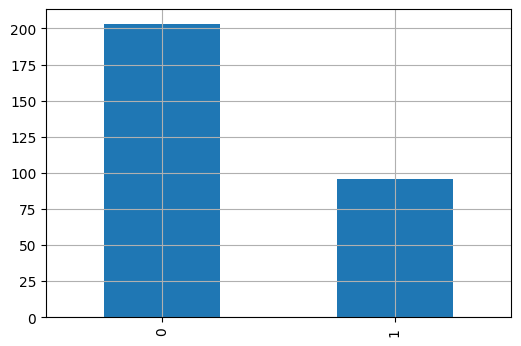

In [ ]:
df['DEATH_EVENT'].value_counts().plot(kind='bar',  grid=True, figsize=(6,4))

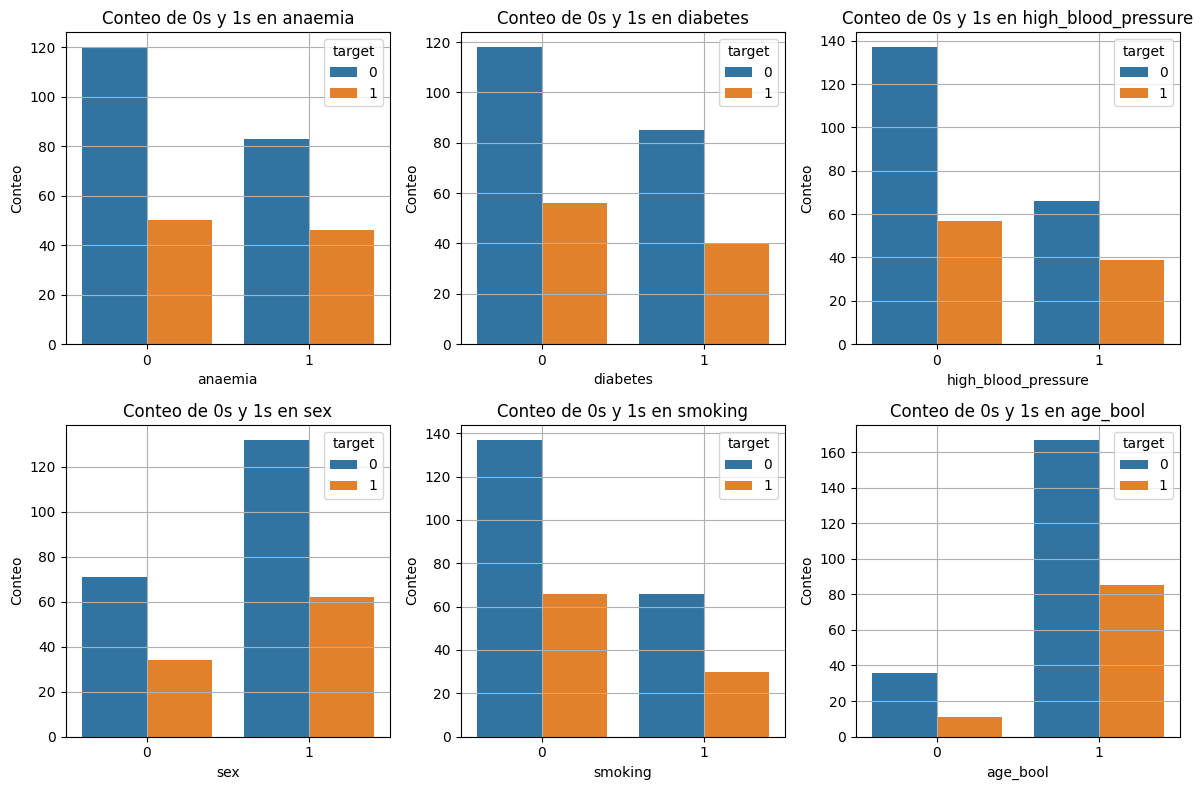

In [ ]:
# Lista de variables booleanas
boolean_data = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking','age_bool']

# Crear un DataFrame filtrado con las variables booleanas y la variable objetivo
df_filtered = df[boolean_data].copy()
df_filtered.loc[:, 'target'] = df['DEATH_EVENT']

# Crear un gráfico de barras para cada variable booleana
plt.figure(figsize=(12, 8))

for i, col in enumerate(boolean_data):
    plt.subplot(2, 3, i+1)
    sns.countplot(data=df_filtered, x=col, hue='target')
    plt.title(f'Conteo de 0s y 1s en {col}')
    plt.xlabel(col)
    plt.ylabel('Conteo')
    plt.grid()

plt.tight_layout()
plt.show()

# Sub Muestreo
---

Len minority_class 96
Len majority_class 203


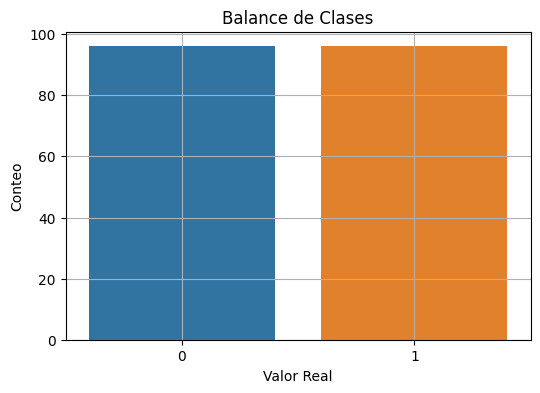

In [ ]:
# Obtener el número de muestras en la clase minoritaria
minority_class = df_filtered[df_filtered['target'] == 1]
majority_class = df_filtered[df_filtered['target'] == 0]
print(f'Len minority_class {len(minority_class)}')
print(f'Len majority_class {len(majority_class)}')

# Realizar submuestreo en la clase mayoritaria
majority_downsampled = resample(majority_class,
                                replace=False,
                                n_samples=len(minority_class),
                                random_state = 42)

# Combinar las clases submuestreada y minoritaria
balanced_df = pd.concat([minority_class, majority_downsampled])

# Mostrar un gráfico de barras para verificar el balance
plt.figure(figsize=(6, 4))
sns.countplot(data=balanced_df, x='target')
plt.title('Balance de Clases')
plt.xlabel('Valor Real')
plt.ylabel('Conteo')
plt.grid()
plt.show()

In [ ]:
balanced_df.sample(1)

,anaemia,diabetes,high_blood_pressure,sex,smoking,age_bool,target
184,1,0,0,1,1,1,1


# Covariables y Target

In [ ]:
target = balanced_df['target']
balanced_df = balanced_df.drop(['target'], axis=1)
# target = df_filtered['target']
# df_filtered = df_filtered.drop(['target'], axis=1)

# Entrenar y optimizar modelo usando el Recall (Sensibilidad)

Elegí utilizar la métrica de sensibilidad (recall) como criterio principal de evaluación debido a la naturaleza crítica de las enfermedades cardiovasculares. Deseo evitar los falsos negativos en la predicción, ya que el peor escenario sería inferir que alguien está en buen estado de salud cuando, en realidad, podría no estarlo. En este contexto, minimizar los falsos negativos es esencial, ya que podría significar que una persona en riesgo de una enfermedad cardiovascular no reciba la atención médica adecuada a tiempo. La sensibilidad se enfoca en identificar correctamente a las personas que están en riesgo, lo que concuerda con el objetivo de detección y manejo temprano de estas enfermedades.

---

Mejor número de vecinos: 1
Mejor sensibilidad alcanzada: 0.67


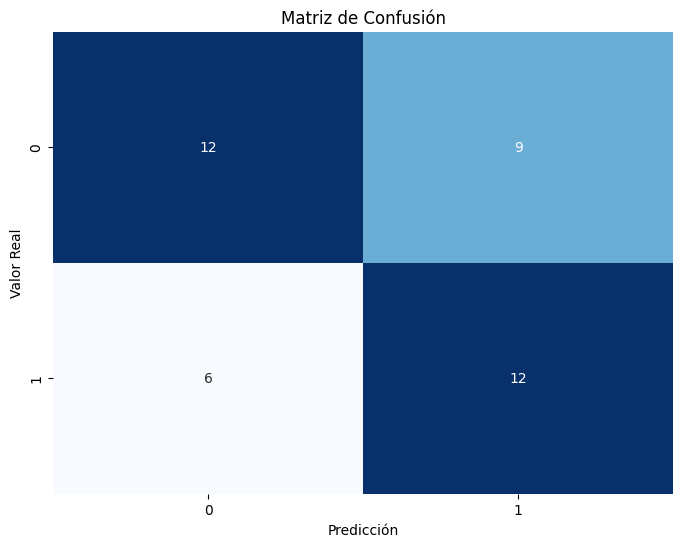

In [ ]:
def train_knn_model(df, target, max_neighbors=10):
    best_sensitivity = 0.0
    best_k = 0
    best_confusion_matrix = None

    X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=42)

    for k in range(1, max_neighbors + 1):
        knn_model = KNeighborsClassifier(n_neighbors=k, metric='hamming')
        knn_model.fit(X_train, y_train)
        y_pred = knn_model.predict(X_test)
        sensitivity = recall_score(y_test, y_pred)

        if sensitivity >= best_sensitivity:
            best_sensitivity = sensitivity
            best_k = k
            best_confusion_matrix = confusion_matrix(y_test, y_pred)

            # Guardar el modelo optimizado en un archivo
            modelo_guardar = f'modelo_knn_optimizado_{str(np.round(sensitivity, 3)).replace(".", "")}.pkl'
            with open(modelo_guardar, 'wb') as model_file:
                pickle.dump(knn_model, model_file)

        else:
            # Detener el bucle si la sensibilidad disminuye
            break

    return best_k, best_sensitivity, best_confusion_matrix

# Llamada a la función con el DataFrame y la variable objetivo
best_k, best_sensitivity, confusion_matrix_result = train_knn_model(balanced_df, target, max_neighbors=10)

print(f"Mejor número de vecinos: {best_k}")
print(f"Mejor sensibilidad alcanzada: {best_sensitivity:.2f}")

# Graficar la matriz de confusión con Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_result, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
balanced_df.sample(3)

,anaemia,diabetes,high_blood_pressure,sex,smoking,age_bool
4,1,1,0,0,0,1
95,1,0,1,1,0,1
99,1,1,0,0,0,1


In [ ]:
pd.DataFrame(target)

,target
0,1
1,1
2,1
3,1
4,1
...,...
87,0
234,0
290,0
99,0
